# Mathe Macht Medikamente: die Simulation
Jitao David Zhang, Rigani Jegatheeswaran, und David Weber

*Mathe Macht Medikamente* ist ein Workshop im Rahmen von Nationen Zukunftstag von Roche am 13.11. Der Workshop ist für Kinder zwischen 5. und 7. Klasse und deren Eltern konzipiert. Mehr Information über den Workshop ist [hier in einer Google Dokument](https://docs.google.com/document/d/1UBZIqVgjBpYKxbMi2KZX1lr_SdCBscWbLFOQXIVed80/edit?usp=sharing) zu finden.

Der Workshop findet zweimal statt: einmal am Morgen und einmal am Nachmittag. Die Daten sind nur für jeweilige Session gespeichert, und danach werden gelöscht.

Für dieses Event planen wir maximum 30 Teams.

## Vorbereitungen

Jedes Kind/Elternteil paar bekommt ein Papier, darauf steht fünf QR codes und andere Informationen:

Tech Check: Team eingeben
Spiel 1: Körpergrösse
Spiel 2: Umfang
Spiel 3: Klinische Studie #1
Spiel 4: Klinische Studie #2

In [16]:
import random
import pandas as pd
import numpy as np
from itables import show
import matplotlib.pyplot as plt

n_teilnahme = 25
random.seed(1887)

In [1]:
## Teams: ChatGPT, https://chatgpt.com/share/e/68f8f919-f328-8009-adbf-f3c76574926e
with open('data/animals.txt', 'r') as tn:
    all_team_namen_str = filter(bool, tn.read().split("\n")) ## the filter/book trick removes ANY empty string
    all_team_namen = dict(item.split(":") for item in all_team_namen_str)
## Kindervornamen: https://www.bfs.admin.ch/bfs/de/home/statistiken/bevoelkerung/geburten-todesfaelle/vornamen-neugeborene.assetdetail.540003.html
with open('data/kinder_vornamen.txt', 'r') as kf:
    kinder_vornamen = list(filter(bool, kf.read().splitlines()))
## Elternvornamen: https://www.bfs.admin.ch/bfs/de/home/statistiken/bevoelkerung/geburten-todesfaelle/namen-schweiz.html, Jahrgang 1984
with open('data/eltern_vornamen.txt', 'r') as ef:
    eltern_vornamen = list(filter(bool, ef.read().splitlines()))

In [2]:
all_team_namen_de = list(all_team_namen.keys())
all_team_namen_en = list(all_team_namen.values())

In [3]:
team_namen_de = random.sample(all_team_namen_de, n_teilnahme)
team_namen_en = [all_team_namen[k] for k in team_namen_de]
team_kind_vornamen = random.choices(kinder_vornamen, k=n_teilnahme) ## choices sample WITH replacement, samples WITHOUT replacement
team_eltern_vornamen = random.choices(eltern_vornamen, k=n_teilnahme)

In [4]:
team_df = pd.DataFrame({'Team_de':team_namen_de,
                        'Team_en':team_namen_en,
                        'Eltern': team_eltern_vornamen,
                        'Kind': team_kind_vornamen})

## Tech Check: Team und Namen eingeben

Jedes Team (Eltern + Kind) scannt den QR code (jedes Team, i.e. auf jedem Papier, hat ein eigenes QR Code). Der Server fragt nach Vornamen von dem Elternteil und dem Kind.

Ergebnisse:

* Eine Tabelle mit alle Teamnamen, die benutzt werden, und der Vornamen von Kindern und Eltern. Die Tabelle soll spaltenweise sortierbar sein.
* Eine Tabelle mit allen einzigartigen Vornamen, und deren Frequenz untern Eltern, Kindern, und beiden.

In [5]:
show(team_df, paging=False)

Loading ITables v2.5.2 from the internet... (need help?)


In [7]:
team_all_namen = team_eltern_vornamen + team_kind_vornamen
team_all_namen_frequenz = pd.Series(team_all_namen).value_counts().reset_index()
team_all_namen_frequenz.columns = ['Name', 'Frequenz']
show(team_all_namen_frequenz)

Loading ITables v2.5.2 from the internet... (need help?)


## Spiel 1: Körpergrössen

Eingaben:

* Teamname
* Grösse von dem Elternteil, in centimeter (validation: nummer, und centimeter, NICHT meter, i.e. >10)
* Grösse von dem Kind, in centimeter

In [ ]:
np.random.seed(1887)
eltern_groesse, kind_groesse = np.random.multivariate_normal(mean=[180, 120], cov=[[15, 7], [7, 12]], size=n_teilnahme).T

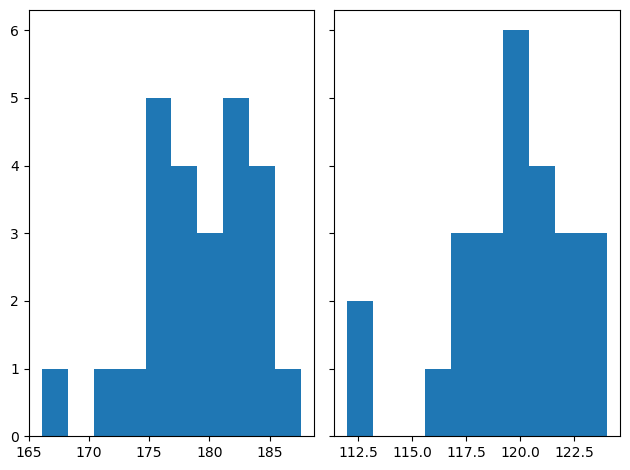

In [25]:
n_bins = 10
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(eltern_groesse, bins=n_bins)
axs[1].hist(kind_groesse, bins=n_bins)

plt.show()

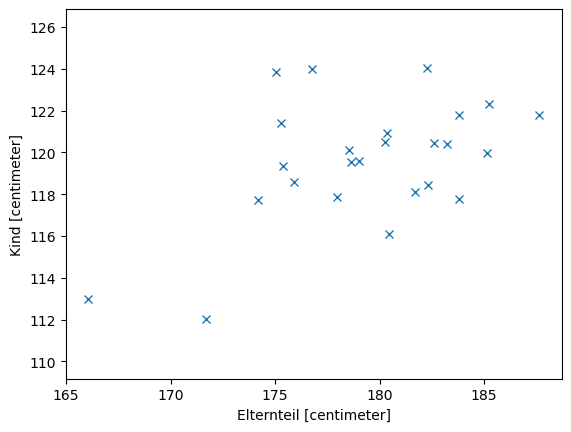

In [22]:

plt.plot(eltern_groesse, kind_groesse, "bo")
plt.xlabel("Elternteil [centimeter]")
plt.ylabel("Kind [centimeter]")
plt.axis('equal')
plt.show()

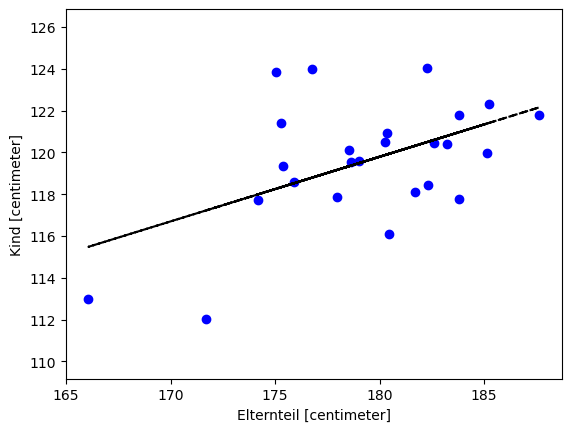

In [24]:
coef = np.polyfit(eltern_groesse, kind_groesse,1)
poly1d_fn = np.poly1d(coef) 

plt.plot(eltern_groesse, kind_groesse, 'bo', eltern_groesse, poly1d_fn(eltern_groesse), '--k')
plt.xlabel("Elternteil [centimeter]")
plt.ylabel("Kind [centimeter]")
plt.axis('equal')
plt.show()

## Spiel 2